In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
random.seed(42)
np.random.seed(42)
#tf.set_random_seed(102)
# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['test_images', 'train.csv', 'test.csv', 'train_images', 'sample_submission.csv']


# load train images

(1050, 1050, 3)


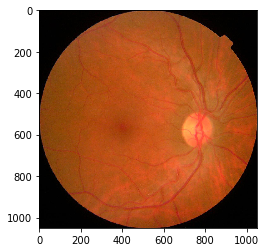

In [2]:
train_img_dir = os.path.join("../input", 'train_images')
train_img_lst = os.listdir(train_img_dir)
path_sample = os.path.join(train_img_dir, train_img_lst[2200])
tensor_sample_img = plt.imread(path_sample)
print(tensor_sample_img.shape)
plt.imshow(tensor_sample_img)

## load the train csv file and repersents how the dataFrame lookslike:

In [3]:
train_csv_path = os.path.join("../input", 'train.csv')
df_train = pd.read_csv(train_csv_path)
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


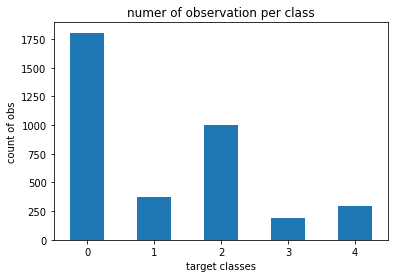

In [4]:
pd.pivot_table(df_train,values='id_code',index='diagnosis',aggfunc=lambda x: len(x.unique())).plot.bar(rot=0)
plt.legend().remove()
plt.xlabel('target classes');
plt.ylabel('count of obs');
plt.title('numer of observation per class');

### we can see that the target data is biased.
### therfore in order to train well a model that will be able to predict properly, will have to up-scale in some method.

------------------------------------------------------
### splits the images into validation and train sets:

In [5]:
imgs_train, imgs_test = train_test_split(train_img_lst, test_size=0.03, random_state=42)
imgs_train, imgs_val = train_test_split(imgs_train, test_size=0.03, random_state=42)

# tune Hyperparams:

82% 400,400

In [6]:
TARGET_SIZE = (300, 300) #resize of the image
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
EPOCHS = 25
UPSCALE_THRESHOLD = 0.25

---------------------------------
## loader functions:

In [7]:
def load_image(image_path):
    """
    gets string of image path and
    load the image into size as in TARGET_SIZE
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=TARGET_SIZE) #resize image
    img = tf.keras.preprocessing.image.img_to_array(img) #Converts a PIL Image instance to a Numpy array.
    img = tf.keras.applications.inception_v3.preprocess_input(img) # pre-process of the input to the
                                                                   # inception model requirements
    return img

In [8]:
def load_batch(df, start_point, X_list, batch_size=BATCH_SIZE, train_loader=True, val_loader=False):
    """
    loads images into batches as requested
    inputs:
    df - the train df to extract the target value of the image
    start_point - integer, index of start point in X_list
    X_list - list of images paths
    batch_size - integer, size of the requseted batch to return
    train_loader - boolean
    test_loader - boolen
    
    return: a tuple of 2 numpy arrays: images, y_targets.
    """
    X_train, y_train = [], []
    for img in X_list[start_point:start_point + batch_size]:
        dir_path = train_img_dir if (train_loader or val_loader) else test_img_dir
        path_img = os.path.join(dir_path, img)
        image = load_image(path_img)
        if train_loader or val_loader:
            cur_y = df.loc[df['id_code'] == img[:-4],'diagnosis'].values[0]
            y_train.append(cur_y)
            
        # upscaling process:
        if train_loader and cur_y in (1, 3, 4) and np.random.rand() > UPSCALE_THRESHOLD:
            X_train.append(image)
            y_train.append(cur_y)
        X_train.append(image)
    return np.array(X_train), np.array(y_train).reshape(-1,1)


----------------------------------------------------------
## Build the model:
### the base model is the InceptionV3 which speclized for image detect.
### the base model will be connected in the edge into clasification nural net model.
### we will train the claisifcation model only.


In [9]:

base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D(name='average_pool')(x)
clasificator = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu'),
                                   tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(64, activation='relu'),
                                   tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(5, activation='softmax')])(x)

model = tf.keras.Model(inputs=base_model.input, 
                       outputs=clasificator)

87916544/87910968 [==============================] - 4s 0us/step


### in order not to change the built-in wheigts in the inception model, we have to freeze thier tain mode:

In [10]:
for layer in base_model.layers:
    if type(layer) != tf.keras.layers.BatchNormalization:
        layer.trainable = False

## model.compile and print summary of it:

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam() ,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### make a directory to save checkpoints of the model for future uses:

In [12]:
checkpoint_dir = './saves_model_cnn_hapton'
if not os.path.isdir(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

## create the model callbacks for checkpoint saver and Early Stopping:

In [13]:
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,monitor='val_acc', 
                                             save_weights_only=True, save_best_only=True, mode='auto',
                                                         verbose=1)
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)
callbacks = [callback_checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)]

## load the train and validation sets:

In [14]:
X_train, y_train = load_batch(df_train, start_point=0, X_list=imgs_train, batch_size=len(imgs_train))
X_val, y_val = load_batch(df_train, start_point=0, X_list=imgs_val, batch_size=len(imgs_val), train_loader=False,
                          val_loader=True)

In [15]:
train_datagen = ImageDataGenerator(rotation_range=True, vertical_flip=True, horizontal_flip=True)

In [16]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
try:
    model.load_weights(latest)
except AttributeError:
    print('Faild in loading weights')
    pass

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) / BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val, y_val), callbacks=callbacks)

Faild in loading weights
Epoch 1/25
127/126 [==============================] - 103s 810ms/step - loss: 1.0762 - acc: 0.5602 - val_loss: 0.6215 - val_acc: 0.8037
Epoch 2/25
127/126 [==============================] - 77s 604ms/step - loss: 0.8705 - acc: 0.6449 - val_loss: 0.6147 - val_acc: 0.8131
Epoch 3/25
127/126 [==============================] - 80s 633ms/step - loss: 0.8160 - acc: 0.6649 - val_loss: 0.5684 - val_acc: 0.7850
Epoch 4/25
127/126 [==============================] - 80s 629ms/step - loss: 0.7597 - acc: 0.6903 - val_loss: 0.5682 - val_acc: 0.8318
Epoch 5/25
127/126 [==============================] - 80s 630ms/step - loss: 0.7438 - acc: 0.6947 - val_loss: 0.4954 - val_acc: 0.8598
Epoch 6/25
127/126 [==============================] - 80s 631ms/step - loss: 0.6958 - acc: 0.7164 - val_loss: 0.5083 - val_acc: 0.7944
Epoch 7/25
127/126 [==============================] - 80s 632ms/step - loss: 0.7098 - acc: 0.7169 - val_loss: 0.5253 - val_acc: 0.7944
Epoch 8/25
127/126 [=========

KeyboardInterrupt: 

## Test:

In [17]:
X_test, y_test = load_batch(df_train, start_point=0, X_list=imgs_test, batch_size=len(imgs_val),
                            train_loader=False, val_loader=True)
y_test_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_test_pred)

In [37]:
acc_score = accuracy_score(y_test, y_test_pred)
print(f'the accuracy on the test data set is {np.round(acc_score, 2)}')

the accuracy on the test data set is 0.83


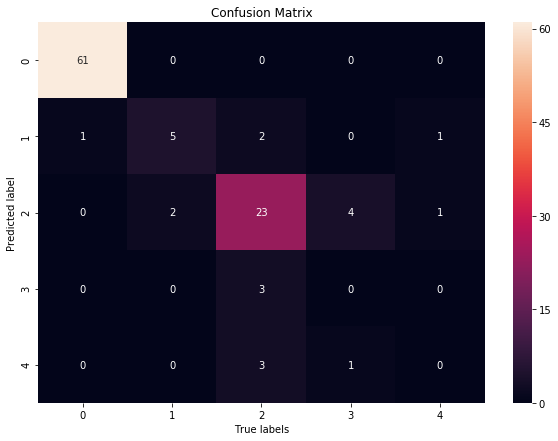

In [38]:
plt.figure(figsize = (10,7))
df_conf_mat = pd.DataFrame(cm, range(5), range(5))
ax = sn.heatmap(df_conf_mat, annot=True)
ax.set_title('Confusion Matrix');
ax.set_xlabel('True labels');
ax.set_ylabel('Predicted label');

In [35]:
from sklearn.metrics import f1_score
score = f1_score(y_test, y_test_pred, average='weighted')
print(f'the f1_score on the test data set is {np.round(score, 2)}')

the f1_score on the test data set is 0.83


In [ ]:
"""for epoch in range(EPOCHS):
    print('*************************************************************\nepoch num:', epoch + 1)
    #np.random.shuffle(imgs_train)
    for counter, i in enumerate(range(0, len(imgs_train), BATCH_SIZE)):
        print('* start batch num',counter + 1)
        X_train, y_train = load_batch(df_train, start_point=i, X_list=imgs_train)
        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied)
        train_datagen.fit(X_train)
        print('starting the train progress...')
        # fits the model on batches with real-time data augmentation:
        model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=X_train.shape[0]), epochs=1,
                            validation_data=(X_val, y_val), callbacks=callbacks)"""

# test:

In [ ]:
test_img_dir = os.path.join("../input", 'test_images')
test_img_lst = os.listdir(train_img_dir)
test_csv_path = os.path.join("../input", 'test.csv')
df_test = pd.read_csv(train_csv_path)
df_test.head()

In [ ]:
X_test, y_test = load_batch(df_test, start_point=0, X_list=test_img_lst, batch_size=len(test_img_lst))

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
sub = pd.DataFrame(y_test_pred.argmax(axis=1))

In [ ]:
sub.to_csv('submission.csv',index=False)